Notebook basado en el artículo:
What is the expectation maximization algorithm?, by Chuong B Do & Serafim Batzoglou
http://ai.stanford.edu/~chuongdo/papers/em_tutorial.pdf

In [10]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

Definir una funcion que muestre la distribucion binomial

In [36]:
def plot_binomial(p=0.5, n=10):
    a=range(n)
    fig, ax = plt.subplots(figsize=(6,4))
    y = [0]*n
    for i in a:
        y[i-1] =  stats.binom.pmf(i, 10, p)
    ax.bar(a,y,label="$p = %.1f$" % p)
    ax.set_ylabel('FMP del nro. de caras')
    ax.set_xlabel('$k$')
    ax.set_ylim((0,0.5))
    ax.set_xlim((0,10))
    ax.legend()
    return fig

Mostrar la distribucion Binomial

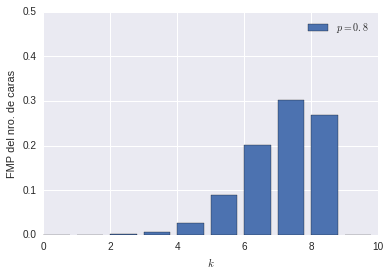

In [37]:
f = plot_binomial(0.8)

## Simular un experimento:

In [13]:
Nexp = 5   # numero de experimentos (monedas)
Nsor = 10  # numero de veces que tiro la moneda en cada experimento
pA = 0.4   # probabilidad de que salga cara en la moneda A
pB = 0.6   # probabilidad de que salga cara en la moneda B
pM = 0.5   # probabiidad de elegir la moneda A
obs = np.empty([Nexp, Nsor], dtype=bool)

In [14]:
def gen_bernoulli(p):
    x = random.random()
    if x<p:
        r = True
    else:
        r = False
    return(r)

In [15]:
def monedas(emA):
    As = np.array(["A"]*5)
    Bs = np.array(["B"]*5)
    T = As
    T[emA] = As[emA]
    T[~emA] = Bs[~emA]
    return(T)

In [16]:
def eP(emA, pA, pB):
    As = np.array(["A"]*5)
    Bs = np.array(["B"]*5)
    T = As
    T[emA] = As[emA]
    T[~emA] = Bs[~emA]
    return(T)

Monedas:

In [17]:
mA = np.array([gen_bernoulli(pM) for _ in range(Nexp)])
#T = monedas(mA)
#print(T)

Tiradas de las monedas:

In [18]:
Nexp = 5
for i in range(Nexp):
    
    if(mA[i]):
        p = pA
    else:
        p = pB
        
    obs[i] = [gen_bernoulli(0.5) for _ in range(Nsor)]

------------------------------------>> Objetivo: estimar pA y pB <<----------------------------------------

## Estimaciones de la probabilidad: Caso "completo"

![title](EM1.png)

In [19]:
fA = 1.0 * np.sum(obs[mA]) / np.size(obs[mA])
fB = 1.0 * np.sum(obs[~mA]) / np.size(obs[~mA])
print(pA, fA, pB, fB)

(0.4, 0.5, 0.6, 0.6)


/store/TeachJob/AstrometriaI/pythings/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


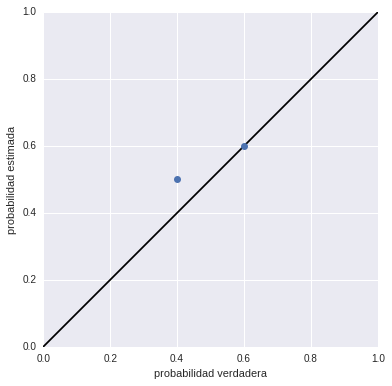

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot([0,1],[0,1],"k-")
plt.plot([pA,pB],[fA,fB],"o")
ax.set_xlabel('probabilidad verdadera')
ax.set_ylabel('probabilidad estimada')
ax.set_ylim((0,1))
ax.set_xlim((0,1))
ax.legend()

## Estimaciones de la probabilidad: Caso "incompleto": 
## Aplicación del algoritmo de expectación-maximización

#### paso 1: asumir valores para los parámetos pA y pB (desconocidos)

In [21]:
epA = 0.6
epB = 0.5

#### paso 2: determinar para cada experimento cual de las monedas es la más probable

In [22]:
# Experimento 1:
print(obs[0])
Ncaras = np.sum(obs[0])
L_A1 = stats.binom.pmf(Ncaras,Nsor,epA)
L_B1 = stats.binom.pmf(Ncaras,Nsor,epB)
print(L_A1, L_B1)

[ True  True  True False False False  True False  True False]
(0.20065812480000034, 0.24609375000000025)


In [23]:
# para los 5 experimentos:
emA = []
for X in obs:
    Ncaras = np.sum(X)
    L_A = stats.binom.pmf(Ncaras,Nsor,epA)
    L_B = stats.binom.pmf(Ncaras,Nsor,epB)
    if(L_A>L_B): 
        S="A"
        emA.append(True)
    else:
        S="B"
        emA.append(False)
    print('La moneda más probable es la {}.  Valores: {} y {}'.format(S, L_A, L_B))
emA = np.array(emA)

La moneda más probable es la B.  Valores: 0.2006581248 y 0.24609375
La moneda más probable es la A.  Valores: 0.120932352 y 0.0439453125
La moneda más probable es la A.  Valores: 0.120932352 y 0.0439453125
La moneda más probable es la A.  Valores: 0.250822656 y 0.205078125
La moneda más probable es la B.  Valores: 0.010616832 y 0.0439453125


In [24]:
print(emA)
print(monedas(emA))

[False  True  True  True False]
['B' 'A' 'A' 'A' 'B']


#### paso 3: 

#### IDEA: _asumo_ estos valores para las variables latentes y estimo los parámetros usando _maximum likelihood_

In [25]:
# Lo mismo que para el caso completo, pero usando emA en lugar de mA:

fA = 1.0 * np.sum(obs[emA]) / np.size(obs[emA])
fB = 1.0 * np.sum(obs[~emA]) / np.size(obs[~emA])
print(pA, fA, pB, fB)

(0.4, 0.7333333333333333, 0.6, 0.35)


#### Repito lo mismo hasta convergencia:

In [26]:
# estima inicial
epA = 0.9
epB = 0.1
print(emA, epA, epB)

for _ in range(10):
    emA = []
    for X in obs:
        Ncaras = np.sum(X)
        L_A = stats.binom.pmf(Ncaras,Nsor,epA)
        L_B = stats.binom.pmf(Ncaras,Nsor,epB)
        if(L_A>L_B): 
            emA.append(True)
        else:
            emA.append(False)
    emA = np.array(emA)
    
    epA = 1.0 * np.sum(obs[emA]) / np.size(obs[emA])
    epB = 1.0 * np.sum(obs[~emA]) / np.size(obs[~emA])
    print(emA, epA, epB)

(array([False,  True,  True,  True, False], dtype=bool), 0.9, 0.1)
(array([False,  True,  True,  True, False], dtype=bool), 0.7333333333333333, 0.35)
(array([False,  True,  True,  True, False], dtype=bool), 0.7333333333333333, 0.35)
(array([False,  True,  True,  True, False], dtype=bool), 0.7333333333333333, 0.35)
(array([False,  True,  True,  True, False], dtype=bool), 0.7333333333333333, 0.35)
(array([False,  True,  True,  True, False], dtype=bool), 0.7333333333333333, 0.35)
(array([False,  True,  True,  True, False], dtype=bool), 0.7333333333333333, 0.35)
(array([False,  True,  True,  True, False], dtype=bool), 0.7333333333333333, 0.35)
(array([False,  True,  True,  True, False], dtype=bool), 0.7333333333333333, 0.35)
(array([False,  True,  True,  True, False], dtype=bool), 0.7333333333333333, 0.35)
(array([False,  True,  True,  True, False], dtype=bool), 0.7333333333333333, 0.35)


#### EM: en lugar de elegir la moneda "más probable", tomo una probabilidad para cada moneda

En la version anterior, asignamos "probabilidades" 0 y 1 a las monedas según cual era la más probable, es decir, asumimos la variable latente como conocida.   Ahora vamos a asignarle una probabilidad a cada moneda.

Para el experimento 1:

In [27]:
obs = np.array([[1,0,0,0,1,1,0,1,0,1],
                [1,1,1,1,0,1,1,1,1,1],
                [1,0,1,1,1,1,1,0,1,1],
                [1,0,1,0,0,0,1,1,0,0],
                [0,1,1,1,0,1,1,1,0,1]])
mA = np.array([False,True,True,False,True])
epA = 0.6
epB = 0.5

In [28]:
Ncaras = np.sum(obs[0])

L_A = stats.binom.pmf(Ncaras,Nsor,epA)
L_B = stats.binom.pmf(Ncaras,Nsor,epB)

# EXPECTACION

mpA = L_A / (L_A + L_B)
mpB = L_B / (L_A + L_B)

print (L_A, L_B, mpA, mpB)

(0.20065812480000034, 0.24609375000000025, 0.4491489261009366, 0.5508510738990634)


El **modelo** ahora es la distribunción Binomial con los parámetros estimados **mpA** y **mpB**

Ahora hacemos el paso de MAXIMIZACION

In [29]:
eCA = Ncaras*mpA
eXA = Ncaras*mpA
eCB = Ncaras*mpB
eXB = Ncaras*mpB

print(eCA, eXA, eCB, eXB)

(2.2457446305046829, 2.2457446305046829, 2.7542553694953171, 2.7542553694953171)


Para los 5 experimentos:

In [30]:
eCAT = []
eXAT = []
eCBT = []
eXBT = []

for X in obs:    
    Ncaras = np.sum(X)
    L_A = stats.binom.pmf(Ncaras,Nsor,epA)
    L_B = stats.binom.pmf(Ncaras,Nsor,epB)
    mpA = L_A / (L_A + L_B)
    mpB = L_B / (L_A + L_B)
    
    eCA = Ncaras*mpA
    eCAT.append(eCA)
    
    eXA = (Nsor-Ncaras)*mpA
    eXAT.append(eXA)    
    
    eCB = Ncaras*mpB
    eCBT.append(eCB)
        
    eXB = (Nsor-Ncaras)*mpB
    eXBT.append(eXB)
        

print(np.sum(eCAT), np.sum(eXAT), np.sum(eCBT), np.sum(eXBT))
    

(21.297481896347225, 8.5722466145301759, 11.702518103652775, 8.4277533854698223)


![title](EM2.png)

In [31]:
epA = np.sum(eCAT) / (np.sum(eCAT) + np.sum(eXAT))
epB = np.sum(eCBT) / (np.sum(eCBT) + np.sum(eXBT))

print(epA, epB)

(0.71301223540051617, 0.58133930831366265)


## PASO 3: EM

In [32]:
epA = 0.6
epB = 0.5

ipA = []
ipB = []

for itera in range(10):

    eCAT = []
    eXAT = []
    eCBT = []
    eXBT = []

    for X in obs:
               
        Ncaras = np.sum(X)
        L_A = stats.binom.pmf(Ncaras,Nsor,epA)
        L_B = stats.binom.pmf(Ncaras,Nsor,epB)
        mpA = L_A / (L_A + L_B)
        mpB = L_B / (L_A + L_B)
        
        eCA = Ncaras*mpA
        eCAT.append(eCA)
        
        eXA = (Nsor-Ncaras)*mpA
        eXAT.append(eXA)    
        
        eCB = Ncaras*mpB
        eCBT.append(eCB)
            
        eXB = (Nsor-Ncaras)*mpB
        eXBT.append(eXB)
        
    epA = np.sum(eCAT) / (np.sum(eCAT) + np.sum(eXAT))
    epB = np.sum(eCBT) / (np.sum(eCBT) + np.sum(eXBT))
    
    ipA.append(epA)
    ipB.append(epB)
    
    print(itera+1, epA, epB)
    

(1, 0.71301223540051617, 0.58133930831366265)
(2, 0.74529203608199457, 0.5692557501718728)
(3, 0.76809883436732096, 0.54953591413834779)
(4, 0.7831645842999736, 0.53461745414752027)
(5, 0.79105524586375275, 0.52628116702993188)
(6, 0.79453253799369938, 0.52239043751787473)
(7, 0.7959286672497986, 0.52072987808602578)
(8, 0.79646563792252645, 0.52004718900298763)
(9, 0.79666830789843945, 0.5197703896938074)
(10, 0.79674414947521166, 0.51965866220411228)


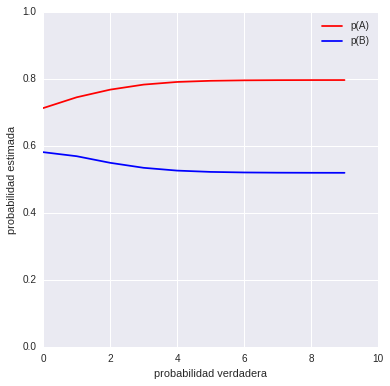

In [33]:
x = range(10)

fig, ax = plt.subplots(figsize=(6,6))
l1 = plt.plot(x, ipA,"r-", label="A")
l2 = plt.plot(x, ipB,"b-", label="B")
ax.set_xlabel('probabilidad verdadera')
ax.set_ylabel('probabilidad estimada')
ax.set_ylim((0,1))
ax.set_xlim((0,10))
ax.legend(labels=["p(A)", "p(B)"])